### Libraries

In [25]:
import numpy as np
import keras.backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import pandas as pd

### Import file

In [26]:
file_name = 'text.txt'
corpus = open(file_name).readlines()
#print(corpus)

### Data preprocessing


In [27]:
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

# Remove punctuation in text and fit tokenizer on entire corpus

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
#print(corpus)

corpus = tokenizer.texts_to_sequences(corpus) # Convert text to sequence of integer values
n_samples = sum(len(s) for s in corpus)       # Total number of words in the corpus
V = len(tokenizer.word_index) + 1             # Total number of unique words in the corpus

In [28]:
#print(n_samples,V)

In [29]:
# Example of how word to integer mapping looks like in the tokenizer
print(list((tokenizer.word_index.items())))

[('the', 1), ('of', 2), ('amnesia', 3), ('in', 4), ('to', 5), ('can', 6), ('memory', 7), ('and', 8), ('a', 9), ('is', 10), ('that', 11), ('information', 12), ('with', 13), ('also', 14), ('be', 15), ('are', 16), ('new', 17), ('caused', 18), ('damage', 19), ('or', 20), ('anterograde', 21), ('ability', 22), ('by', 23), ('was', 24), ('two', 25), ('types', 26), ('retrograde', 27), ('inability', 28), ('retrieve', 29), ('date', 30), ('loss', 31), ('may', 32), ('term', 33), ('store', 34), ('long', 35), ('people', 36), ('both', 37), ('occur', 38), ('studies', 39), ('addition', 40), ('specific', 41), ('areas', 42), ('shown', 43), ('damaged', 44), ('have', 45), ('rbap48', 46), ('protein', 47), ('able', 48), ('mice', 49), ('recall', 50), ('still', 51), ('learn', 52), ('patients', 53), ('knowledge', 54), ('learning', 55), ('deficit', 56), ('brain', 57), ('disease', 58), ('but', 59), ('it', 60), ('temporarily', 61), ('use', 62), ('various', 63), ('sedatives', 64), ('hypnotic', 65), ('drugs', 66), ('

In [30]:
# Parameters
window_size = 2 
window_size_corpus = 4

# Set numpy seed for reproducible results
np.random.seed(42)

In [31]:
from keras.preprocessing import sequence

# Prepare the data for the CBOW model
def generate_data_cbow(corpus, window_size, V):
    all_in = []
    all_out = []

    # Iterate over all sentences
    for sentence in corpus:
        L = len(sentence)
        for index, word in enumerate(sentence):
            start = index - window_size
            end = index + window_size + 1

            # Empty list which will store the context words
            context_words = []
            for i in range(start, end):
                # Skip the 'same' word
                if i != index:
                    # Add a word as a context word if it is within the window size
                    if 0 <= i < L:
                        context_words.append(sentence[i])
                    else:
                        # Pad with zero if there are no words 
                        context_words.append(0)
            # Append the list with context words
            all_in.append(context_words)

            # Add one-hot encoding of the target word
            all_out.append(to_categorical(word, V))
                 
    return (np.array(all_in), np.array(all_out))

In [32]:
# Create the training data

X_cbow, y_cbow = generate_data_cbow(corpus, window_size, V)
print('X_cbow = ',X_cbow,'\ny_cbow[0] = ',y_cbow[0])


X_cbow =  [[  0   0  10   9]
 [  0   3   9  56]
 [  3  10  56   4]
 ...
 [167   4  55 169]
 [  4 168 169   0]
 [168  55   0   0]] 
y_cbow[0] =  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


### CBOW 

In [33]:
# Create the CBOW architecture
dim = 10

#for dim in dims:
cbow = Sequential()

    # Add an Embedding layer
cbow.add(Embedding(input_dim=V, 
                   output_dim=dim,
                   input_length = window_size*2, # Note that we now have 2L words for each input entry
                   embeddings_initializer='glorot_uniform'))

cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim, )))

cbow.add(Dense(V, activation='softmax', kernel_initializer='glorot_uniform'))

cbow.compile(optimizer=keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
    
cbow.summary()
print("")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 10)             1700      
_________________________________________________________________
lambda (Lambda)              (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 170)               1870      
Total params: 3,570
Trainable params: 3,570
Non-trainable params: 0
_________________________________________________________________



In [34]:
# Train CBOW model
cbow.fit(X_cbow, y_cbow, batch_size=64, epochs=500, verbose=1)
print("")

Epoch 1/500
5/5 [==============================] - 3s 4ms/step - loss: 5.1366 - accuracy: 0.0000e+00
Epoch 2/500
5/5 [==============================] - 0s 4ms/step - loss: 5.1326 - accuracy: 0.0031
Epoch 3/500
5/5 [==============================] - 0s 4ms/step - loss: 5.1292 - accuracy: 0.0063
Epoch 4/500
5/5 [==============================] - 0s 4ms/step - loss: 5.1259 - accuracy: 0.0126
Epoch 5/500
5/5 [==============================] - 0s 4ms/step - loss: 5.1226 - accuracy: 0.0189
Epoch 6/500
5/5 [==============================] - 0s 4ms/step - loss: 5.1193 - accuracy: 0.0189
Epoch 7/500
5/5 [==============================] - 0s 4ms/step - loss: 5.1160 - accuracy: 0.0346
Epoch 8/500
5/5 [==============================] - 0s 4ms/step - loss: 5.1126 - accuracy: 0.0377
Epoch 9/500
5/5 [==============================] - 0s 4ms/step - loss: 5.1092 - accuracy: 0.0440
Epoch 10/500
5/5 [==============================] - 0s 4ms/step - loss: 5.1058 - accuracy: 0.0503
Epoch 11/500
5/5 [=======

### PCA

In [35]:
# Weights of the model
weights = cbow.get_weights()

# Get the embedding matrix
embedding = weights[0]
#print(embedding)

In [36]:
def add_0():
  words = list((tokenizer.word_index.items()))
  words.insert(0,('unkown',0))
  return words

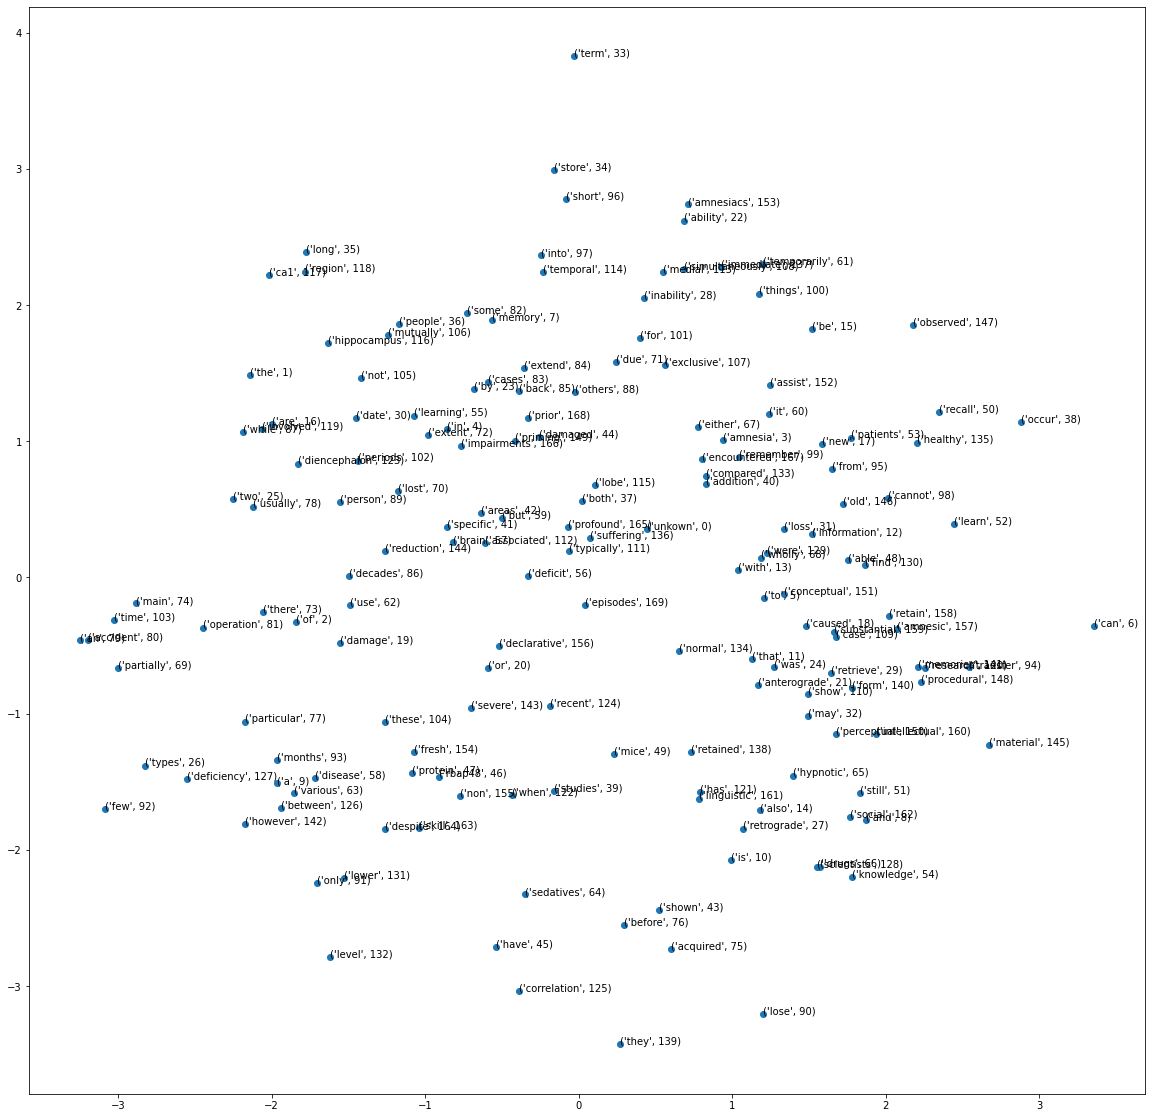

In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
final_result = pca.fit_transform(embedding)
fig, ax = plt.subplots(1,1,figsize = (20,20))
plt.scatter(final_result[:,0], final_result[:,1])
for i, word in enumerate(words):
    ax.annotate(word, xy = (final_result[i, 0], final_result[i, 1]))

### Output Prediction

In [66]:
# Function to get embedding vectors of a particular word

def embed(word, embedding, vocab_size=V, tokenizer=tokenizer):
    int_word = tokenizer.texts_to_sequences([word])[0]
    bin_word = to_categorical(int_word, V)
    return np.dot(bin_word, embedding)
#print(embed('amnesia',embedding))

In [67]:
# Function to check which word a given y_cbow[i] stands for

def know_word(y_cbow):
  for i in range(len(y_cbow)):
    if y_cbow[i] == 1 :
      break
  return words[i][0]  
#print(know_word(y_cbow[0]))

In [68]:
# Output(middle) word prediction

def output_word(input):
  input_tokens = tokenizer.texts_to_sequences(input)
  #print(input_tokens)
  for i in range(len(cbow.predict(input_tokens)[0])):
    if cbow.predict(input_tokens)[0][i] == cbow.predict(input_tokens)[0].max() :
      break
  return words[i][0]

In [69]:
input_words = [input("Enter the neighbouring words (separated by spaces) :")]
print('input words = ',input_words)

Enter the neighbouring words (separated by spaces) :inability to new information
input words =  ['inability to new information']


In [70]:
print(output_word(input_words))

'new'